In [ ]:
import sys

from collections import defaultdict
from dataclasses import dataclass, field
from typing import Any, Callable, Optional, Union
from pathlib import Path

from rdkit import Chem
from openff.units import unit

from openff.toolkit.utils import toolkit_registry
from openff.toolkit.utils.toolkits import RDKitToolkitWrapper, OpenEyeToolkitWrapper, AmberToolsToolkitWrapper

from openff.toolkit.topology import Topology
from openff.toolkit.topology.molecule import FrozenMolecule, Molecule

## Useful functions for charge averaging

In [ ]:
def generate_charged_molecule(pdbfile, substructure_file, toolkit_method='openeye'):
    # mol should already have one conformer...
    toolkits = {
        'openeye' : OpenEyeToolkitWrapper,
        'ambertools' : AmberToolsToolkitWrapper
    }

    off_topology, _, error = Topology.from_pdb_and_monomer_info(pdbfile, substructure_file, strict=True)
    # here, we assume that the topology only has ONE simple homopolymer. Later, all molecules can be extracted and charged
    mol = next(off_topology.molecules) # get the first molecule
    # get some conformers to run elf10 charge method. By default, `mol.assign_partial_charges`
    # uses 500 conformers, but we can generate and use 10 here for demonstration
    # mol.generate_conformers(
    #     n_conformers=10,
    #     rms_cutoff=0.25 * unit.angstrom,
    #     make_carboxylic_acids_cis=True,
    #     toolkit_registry=RDKitToolkitWrapper()
    # ) # very slow for large polymers! 

    # finally, assign partial charges using those 10 conformers generated 
    mol.assign_partial_charges(
        partial_charge_method='am1bcc', 
        toolkit_registry=toolkits.get(toolkit_method)()
    )
    # code for exact how the above function works can be found in openff/toolkit/utils/openeye_wrapper.py under the assign_partial_charges() function
    return mol

def fetch_charged_mol(filename : str, parent_path : Path=Path.cwd()/'compatible_pdbs', extensions=('pdb', 'json'), toolkit_method : str='openeye') -> Optional[Molecule]:
    ''''''
    mol_files = {
        ext : path
            for path in parent_path.glob('**/*.*')
                for ext in extensions
                    if path.name == f'{filename}.{ext}'
    }

    for ext in extensions:
        if ext not in mol_files:
            print(f'Could not find a(n) {ext} file \"{filename}.{ext}\"')
            return
            # sys.exit(0)
    else:
        charged_mol = generate_charged_molecule(str(mol_files['pdb']), mol_files['json'], toolkit_method=toolkit_method)
        print(f'final molecular charges: {charged_mol.partial_charges}')

        # note: the charged_mol has metadata about which monomers were assigned where as a result of the chemicaly info assignment.
        # This can be a way to break up the molecule into repeating sections to partition the library charges 
        for atom in charged_mol.atoms:
            assert(atom.metadata['already_matched'] == True)
            # print(atom.metadata['residue_name'])
        
        return charged_mol


@dataclass
class Accumulator:
    sum : float = 0.0
    count : int = 0

    @property
    def average(self):
        return self.sum / self.count

def averaged_charges_by_SMARTS(cmol : Molecule) -> defaultdict:
    '''Takes a charged molecule and averages charges for each repeating residue
    Returns a dict indexed by SMARTS string of subdicts containing the averaged charges for each atom in the residue'''
    rep_res_nums = defaultdict(set) # numbers of representative groups for each unique residue, used to build SMARTS strings
    for atom in cmol.atoms: 
        rep_res_nums[atom.metadata['residue_name']].add(atom.metadata['residue_number']) # collect unique residue numbers

    for res_name, ids in rep_res_nums.items():
        rep_res_nums[res_name] = min(ids) # choose group with smallest id of each residue to denote representative group
    
    atom_ids_for_SMARTS = defaultdict(list)
    avg_charges_by_res = defaultdict(lambda : defaultdict(Accumulator))
    for atom in cmol.atoms: # accumulate counts and charge values across matching substructures
        res_name = atom.metadata['residue_name'] # for notational convenience, given how often this is used here
        if atom.metadata['residue_number'] == rep_res_nums[res_name]: # collect pdb ids if atom is member of representative group for any residue
            atom_ids_for_SMARTS[res_name].append(atom.metadata['pdb_atom_id'])

        curr_accum = avg_charges_by_res[res_name][atom.metadata['substructure_id']] 
        curr_accum.sum += atom.partial_charge.magnitude
        curr_accum.count += 1

    rdmol = cmol.to_rdkit()
    avg_charges_by_SMARTS = defaultdict(dict)
    for res_name, charge_map in avg_charges_by_res.items():
        SMARTS = Chem.rdmolfiles.MolFragmentToSmarts(rdmol, atomsToUse=atom_ids_for_SMARTS[res_name]) # determine SMARTS for the current residue's representative group

        for substruct_id, accum in charge_map.items():
            avg_charges_by_SMARTS[SMARTS][substruct_id] = accum.average # collapse accumulators into actual average values

    return avg_charges_by_SMARTS

In [ ]:
cmol = fetch_charged_mol('naturalrubber', toolkit_method='openeye')
avgs = averaged_charges_by_SMARTS(cmol)

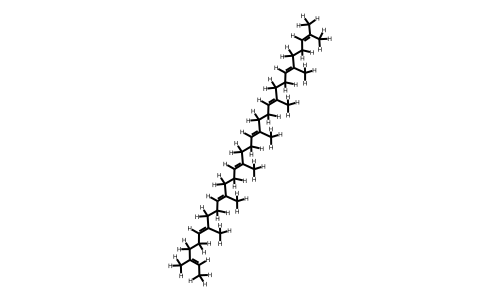

In [5]:
cmol.visualize()

In [7]:
print(avgs)

defaultdict(<class 'dict'>, {'[#6](-[H])(-[H])-[#6](=[#6](-[H])-[#6](-[H])(-[H])-[H])-[#6](-[H])(-[H])-[H]': {0: -0.03956999988207277, 1: 0.04400999858131949, 2: 0.04400999858131949, 3: -0.11754000172862467, 4: -0.1667100040698951, 5: 0.11830999716272894, 6: -0.06148999915370401, 7: 0.03898999854078833, 8: 0.03898999854078833, 10: -0.06092999861487802, 11: 0.03940000026574675, 12: 0.03940000026574675, 13: 0.03940000026574675, 9: 0.03898999854078833}, '[#6](-[H])(-[H])-[#6](=[#6](-[H])-[#6](-[H])-[H])-[#6](-[H])(-[H])-[H]': {3: -0.040736666429530145, 4: 0.04569499953737799, 5: 0.04569499953737799, 2: -0.11052833235113875, 1: -0.16736499951133188, 10: 0.11831666791589006, 0: -0.043763332549224855, 11: 0.046198332822828925, 12: 0.046198332822828925, 6: -0.06138500060487843, 7: 0.04067166660379314, 8: 0.04067166660379314, 9: 0.04067166660379314}, '[#6](-[H])(-[H])(-[H])-[#6](=[#6](-[H])-[#6](-[H])-[H])-[#6](-[H])(-[H])-[H]': {7: -0.060880001493782365, 8: 0.03982999934902731, 9: 0.039829999

## Example for assigning atom ids in SMARTS

In [ ]:
rdmol = cmol.to_rdkit()
smarts_no_map = Chem.rdmolfiles.MolFragmentToSmarts(rdmol, atomsToUse=[i for i in range(5,10)])
# how to specify atom map numbers
i = 0
for atom in rdmol.GetAtoms():
    i += 1
    atom.SetAtomMapNum(atom.GetIdx())
smarts_yes_map = Chem.rdmolfiles.MolFragmentToSmarts(rdmol, atomsToUse=[i for i in range(5,10)])

print(smarts_no_map)
print(smarts_yes_map)

<LibraryCharge smirks="[#6:1](-[#8:3]-[#6:2]([#6]([#8][#6]([H])[H])([H])[H])(-[H:7])-[H:8])(-[H:4])(-[H:5])[H:6]" charge1="0.11772 * elementary_charge" charge3="-0.41516 * elementary_charge" charge2="0.126 * elementary_charge" charge7="0.038690001 * elementary_charge" charge8="0.038690001 * elementary_charge" charge4="0.031090001 * elementary_charge" charge5="0.031090001 * elementary_charge" charge6="0.031090001 * elementary_charge"></LibraryCharge>


In [ ]:
for atom in cmol.atoms:
    print(atom.metadata)

## Playing with NX to get a feel for it

In [ ]:
import networkx as nx

G = nx.Graph()
G.add_node(0, val=6, attr='stuff')
G.add_node(3, val=7, attr='other')
G.nodes[3]['attr']

In [ ]:
G.add_edge(1, 2, weight=10)
G.edges[1, 2]['weight']